<h1 style="color:#239B56;">Robo-Advisor</h1>

## Overview:

We want to create an unusually "safe" portfolio. Rather than maximize returns, we want to keep returns as close as possible to zero. In other words, we want to generate the least volatile portfolio given a list of stocks, with the goal of having the ending value be as close as possible to the starting value, given some investment horizon.

We will be using Python, with tools such as Pandas, NumPy, Matplotlib, and the AlphaVantage API to gather data, perform quantitative analyses, generate the portfolio, and analyze the results.

Table of contents:

_____________________________________________________________________________

0.0 Imports

0.1 Global Variables

1. DATA CLEANING

    1.1 Read in .csv

    1.2 Collect and Filter Data

2. CHOOSING THE STOCKS

    2.1 Returns DataFrame

    2.2 The Points System

3. CREATING THE OPTIMAL PORTFOLIO

    3.1 Stock Betas

    3.2 Weight Generation

    3.3 Monte Carlo Simulation

    3.4 Final Portfolio

4. ANALYSIS AND SANITY CHECKS

    4.1 Value and Weights Check

    4.2 Expected Returns Visualization

    4.3 Returns Check With Low Volatility ETF Comparison

    4.4 Graphed Returns Check With Additional Data and Low Volatility ETF Comparison

5. PORTFOLIO TO CSV, CONSIDERATIONS, AND CONCLUSION

    5.1 Output Final Information to .csv File

    5.2 Considerations

    5.3 Conclusion

6. REFERENCES

_____________________________________________________________________________

Here's a quick overview of the architecture of this script:

Data cleaning - Removing tickers that do not fit certain criteria (chosen by the user).

Choosing the stocks - Picking the tickers which we will utilize in the final portfolio (based on a volatility and correlation metric).

Creating the portfolio - Running a Monte Carlo simulation to generate the final portfolio, which has an expected return close to 0%. We will calculate expected return based on a <b>Multi-Security Capital Asset Pricing Model (MSCAPM)</b> (below).

![MSCAPM](pub/pricing_model.jpg)

Analysis and sanity checks - Ensuring that the capital has been allocated correctly, as well as showing that the portfolio is indeed expected to return close to 0% over a given period of time, among other characteristics. In this section, we also compare our generated portfolio to a popular low-volatility ETF.

Objective assumptions:

- Fractional shares can be purchased
- There will be no transaction costs when buying stocks.
- Once the portfolio is set, it cannot be changed.
- Dividends will be ignored

Note: The term 'stock' and 'ticker' are often used interchangeably in this project. They both generally refer to either the string representing a stock or the underlying stock itself.

## Why MSCAPM?

The Multi-Security Capital Asset Pricing Model (MSCAPM for short) gives the expected return for a portfolio of assets relational to its risk with the market.

One of the primary assumptions we make when deriving the portfolio is that <b>the overall market will be a good indicator for its price movements.</b> This is because we deliberately diversify the portfolio. We use this information to then attempt to offset market movements, allowing the portfolio to hover around 0% returns.

With this assumption in mind, we decided that the MSCAPM was the best pricing model to use for two main reasons:

1. CAPM is a tested and proven model.

2. Including beta as a factor allows us to imply both correlation and volatility in one variable, and will bias the allocation of capital towards stocks that have lower volatility, and/or stocks that are likely to 'offset' the volatility of other stocks in the portfolio.

Some issues with other viable methods:

1. Picking the portfolio with the lowest volatility.
- Doesn't consider correlation strongly. With this model, it's possible for the correlation between securities to be high, which could cause the portfolio's value to trend in one direction over time, despite low volatility. Problematic in the long-term.

2. Picking the portfolio with the lowest expected return (by combining the weighted expected return of each security).
- Doesn't consider volatility heavily. The magnitude of volatility may be strong. Problematic in the short-term.

#### 0.0 Imports

In [225]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

import threading
from queue import Queue
from random import uniform
import random
from typing import List

import sys

from modules.alphawrap import Stock
import modules.alphawrap as aw

### 0.1 Global Variables

In [226]:
# MODIFIABLE #

# AlphaVantage key
KEY                             = ''
aw.set_global_key(KEY)

# Variables for filtering
minimum_monthly_trading_days    = 20 # For a valid month in volume calculation
minimum_volume                  = 200_000 # Monthly, for valid months
required_denomination           = 'USD'

# Maximum number of stocks allowed in the portfolio
max_tickers                     = 25

# Dates for data references made when looking at statistics like volatility, correlation, and beta
#  "Portfolio selection analysis period"
start                           = '2023-01-01'
end                             = '2023-05-02'

# Dates for volume calculation
vol_date_s                      = '2022-08-01'
vol_date_e                      = '2023-02-01' # Must be the month after the last month to be checked

capital                         = 500_000 # How much money we have to spend

# Lowest and highest percentage of any given security in the portfolio
lowest_weight                   = .02
highest_weight                  = .12

numdays                         = 5 # For expected return (NUMBER OF TRADING DAYS ONLY)

In [227]:
# .csv file of tickers
csv_file = "csv/tickers.csv"

# Retrieve risk-free rate from alphawrap library
try:
    rf = aw.rf()
except:
    rf = 0.0383

price_date = end # Date of purchase for stocks

## 1. DATA CLEANING: 

THE GOAL:

• Ignore any tickers that do not reference a valid stock denominated in USD, i.e., we want to only use US-listed stocks.

• Only use tickers that reference stocks with an average monthly volume of at least two-hundred thousand shares, as calculated based on a specified time interval. A month is defined as a calendar month. We will drop any month that does not have at least twenty trading days.

THE PROCESS:

We have two main functions (currency_check and volume_check), running on two separate threads, c and v. These functions are defined recursively; If too many tickers are passed into the function (i.e a list of tickers that is longer than 'max_length_lst' in each function), the function calls on several threads to run the function with smaller, sub-lists. When a small enough quantity of tickers is passed to the function, it will perform the criteria check for the tickers. This allows us to make faster API calls. Valid tickers get passed to the function's respective queue. Finally, the queue is cleared, and tickers that fit both criteria are saved as our list of tickers.

Our code checks the tickers for the criteria mentioned,and generates two lists of valid tickers (one for each criterion). As we want stocks that fit both criteria, our final list of (valid) tickers is the intersection of the two lists.

Note 1: Initially, we had volume_check and currency_check running asynchronously, and passed very small lists of tickers. Due to the limitations of AlphaVantage (an API that was not initially used for this project), we had to throttle the speed of data cleaning by running the functions in succession and increasing the max number of tickers by up to five-hundred percent.

Note 2: Duplicates will be filtered out.

#### 1.1 Read in .csv

In [228]:
# Make values into a list
tickers_csv = pd.read_csv(csv_file)
ticker_list = tickers_csv.iloc[:, 0].values.tolist()
ticker_list.insert(0, tickers_csv.columns[0]) # Add ticker at [0,0] (column name)
ticker_list = [*set(ticker_list)] # Remove duplicates

#### 1.2 Collect and Filter Data

We first define our functions (average_volume (for volume_check), currency_check, volume_check).

In [229]:
# Creates a series of months from vol_date_s to vol_date_e (for average_volume)
months = list(pd.date_range(vol_date_s, vol_date_e, freq = 'MS').strftime("%Y-%m").tolist())

num_months_vol = len(months)

In [230]:
# Consumes a ticker, outputs average volume over valid months
def average_volume(ticker):
    monthly_volumes = []

    tick_obj = Stock(ticker = ticker)

    # Custom DataFrame for valid months check
    df_days = tick_obj.history(start = vol_date_s, end  = vol_date_e, interval = '1d').dropna()

    # Drop months with less than minimum_monthly_trading_days days
    for month in range(num_months_vol):
        # Filter DataFrame for days only in the specified month
        month_data = df_days.filter(like = months[month], axis = 0)

        if len(month_data) >= minimum_monthly_trading_days:
            # Add the sum of volume for that month
            monthly_volumes.append(sum(month_data['Volume'].values.tolist()))
        else:
            pass

    # Calculate average volume
    vol_av = np.mean(monthly_volumes)

    return(vol_av)

In [231]:
valid_tickers = []
currency_valid = []
volume_valid = []

# Queue variables to store tickers while running async
queueC = Queue()
queueV = Queue()

In [232]:
# Consumes a list of tickers, checks if the tickers are denominated in 'required_denomination'
def currency_check(tickers):
    max_length_lst = 35 # Maximum number of tickers that will be accepted by the function, else recursive call

    # When there are an appropriate number of tickers in ticker_list, the function performs the currency check
    if len(tickers) <= max_length_lst:

        # Retrieve currency from each ticker
        #  If it is 'required_denomination', it is a valid ticker. Else, we don't care so we set it as nan
        for ticker in tickers:
            currency = ''
            tick_obj = Stock(ticker = ticker)

            # Grab currency
            try:
                currency = tick_obj.info()['Currency']
            except:
                if currency:
                    print(f'{ticker}: Invalid Currency: {currency}')
                    continue # Suppress errors
                else:
                    print(f'{ticker}: Currency not found, ticker or key may be invalid')
                    continue # Suppress errors
                       
            # Check criteria, add to list of valid tickers for currency
            if currency == required_denomination:
                # Pass our valid tickers to the QueueC (Queue Currency), so that they may be called on later
                queueC.put(ticker)
            else:
                print(f'{ticker}: Invalid currency - {currency}')

    # If there are too many tickers in ticker_lst, we run a recursive application of currency_check with 
    #  num_threads threads, with the arguments being one of num_threads equal parts of 'tickers'.
    else:
        num_threads = 2

        ticker_split = np.array_split(tickers, num_threads)

        # Start num_threads threads, add to list.
        threads = []
        for n in range(num_threads):
            c_sub = threading.Thread(target = currency_check, args = (ticker_split[n], ))
            c_sub.start()
            threads.append(c_sub)

        # Wait for threads to finish.
        for t in threads:
            t.join()

In [233]:
# Consumes a list of tickers, checks if the tickers have an average monthly volume of 'minimum_volume' 
#  or more for months with 'minimum_monthly_trading_days' or more trading days
def volume_check(tickers):
    max_length_lst = 35
    
    # When there are an appropriate number of tickers in ticker_list, the function performs the volume check
    if len(tickers) <= max_length_lst:

        # Retrieve monthly average volume from each ticker
        #  If it is greater than or equal to minimum_volume, it is a valid ticker. Else, we ignore it
        for ticker in tickers:
            
            try:
                av_vol = average_volume(ticker = ticker)
                if av_vol >= minimum_volume:
                    # Pass our valid tickers to the QueueV (Queue Volume), so that they may be called on later
                    queueV.put(ticker)
                else:
                    print(f'{ticker}: Invalid volume - {av_vol}')
            except:
                pass # Suppress errors

    # If there are too many tickers in ticker_lst, we run a recursive application of volume_check with num_threads threads,
    #  with the arguments being one of num_threads equal parts of ticker_list
    else:
        num_threads = 2

        ticker_split = np.array_split(tickers, num_threads)

        # Start num_threads threads, add to list.
        threads = []

        for n in range(num_threads):
            v_sub = threading.Thread(target = volume_check, args = (ticker_split[n], ))
            v_sub.start()
            threads.append(v_sub)

        # Wait for all threads to finish
        for t in threads:
            t.join()

We now run currency_check and volume_check as described in the beginning of this section. All valid tickers are housed in valid_tickers.

In [234]:
# Creating threads for currency_check and volume_check function
c = threading.Thread(target = currency_check, args = (ticker_list, ))
v = threading.Thread(target = volume_check, args = (ticker_list, ))

# Start thread c execution
c.start()

# Wait for c to finish, grab all elements from queue
c.join()
while not queueC.empty():
    currency_valid.append(queueC.get())

# Start thread v execution
v.start()

# Wait for v to finish, grab all elements from queue
v.join()
while not queueV.empty():
    volume_valid.append(queueV.get())

# Valid tickers are the intersection of the two lists (Must have particular denomination and average monthly volume)
valid_tickers = sorted([value for value in currency_valid if value in volume_valid])

print(f"\nValid Tickers: {valid_tickers}")

PSCM: Currency not found, ticker or key may be invalid
NAC: Currency not found, ticker or key may be invalid


QRMI: Currency not found, ticker or key may be invalid
TD.TO: Currency not found, ticker or key may be invalid
MON: Currency not found, ticker or key may be invalid
PSCM: Invalid volume - 36036.333333333336
CIZN: Invalid volume - 114829.83333333333
QRMI: Invalid volume - 109015.0
CVR: Invalid volume - 49843.666666666664
SEB: Invalid volume - 13488.333333333334
BRK-A: Invalid volume - 64494.5
Stock.history: MON: Something went wrong. Dates may be incorrect or out of range

Valid Tickers: ['AAPL', 'ABT', 'ACN', 'ADBE', 'AEE', 'AEP', 'AMZN', 'BA', 'BAC', 'BK', 'BRK-B', 'C', 'CF', 'CMCSA', 'CMS', 'CPB', 'CSCO', 'CVS', 'D', 'ED', 'F', 'GE', 'GILD', 'GM', 'GO', 'GOOG', 'GRMN', 'IBM', 'INFY', 'JPM', 'KO', 'LMT', 'MNSO', 'MS', 'MSFT', 'NOC', 'PG', 'PM', 'REGN', 'ROP', 'SO', 'T', 'TSN', 'TXN', 'UNH', 'UPS', 'VMW', 'VZ']


## 2. CHOOSING THE STOCKS:

In this section, we choose the stocks to be used in the final portfolio.

THE GOAL:

Since our overall goal is to have a portfolio that finishes as close to its starting value as possible, we naturally want a diversified and stable selection of stocks. With this in mind, we decided to use a system which considers correlation and volatility ("the points system"). 

Essentially, we want:

• (If there are less than max_tickers tickers to choose from) Every (valid) ticker available <b>OR</b>
  (if there are more than max_tickers tickers to choose from) 'max_tickers' tickers, comprised of the stocks which earn the most "points" in our points system.

• Note: Volatility, as we define it in this section, is represented by the standard deviation of daily returns:

\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

- Where $x_i$ are individual returns of some security $X$, $N$ is the total number of observations

• Note: Correlation, as we define it in this section, is as follows:

 \begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

Where COV(X,Y) is: 

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

THE PROCESS:

We will obtain closing data for each ticker, and calculate the daily returns. Then, we will use our points system to select the tickers which will be conducive to our goal.

#### 2.1 Returns DataFrame

First we create the closing prices DataFrame.

In [235]:
interval = '1d'
# Dictionary of closing prices
closing_dict = {}
# Dictionary of returns
returns_dict = {}

In [236]:
# Fills closing_dict dictionary with closing prices for each ticker in closing_tickers
for ticker in valid_tickers:
    tick_obj = Stock(ticker = ticker)
    tick_hist = tick_obj.history(start = start, end = end, interval = interval)

    closing_dict[ticker] = tick_hist['Close']

closing_df = pd.DataFrame(closing_dict)

print("Closing Prices Preview:")
closing_df.head()

Closing Prices Preview:


,AAPL,ABT,ACN,ADBE,AEE,AEP,AMZN,BA,BAC,BK,...,REGN,ROP,SO,T,TSN,TXN,UNH,UPS,VMW,VZ
2023-01-03,124.706364,108.034747,267.175735,336.92,87.163629,93.139744,85.82,195.39,33.029731,45.553478,...,720.47,432.497286,70.500820,17.895453,62.496431,160.846554,514.710629,172.089197,122.32,38.161273
2023-01-04,125.992614,109.641762,266.266234,341.41,87.626584,93.777890,85.14,203.64,33.650701,46.675097,...,726.49,440.739881,71.098949,18.277426,63.390641,166.720247,500.677758,173.885883,122.92,39.121963
2023-01-05,124.656510,109.237543,259.978816,328.44,84.710952,92.069624,83.12,204.99,33.581705,46.448805,...,723.76,433.950691,69.010399,18.344271,63.243244,164.512684,486.247917,170.675410,121.73,39.664135
2023-01-06,129.243135,110.745968,266.137718,332.75,86.996177,94.769469,86.08,213.00,33.916832,47.176874,...,737.15,442.345096,70.236074,18.649850,64.923573,172.623506,486.287614,175.692388,126.14,40.130212
2023-01-09,129.771594,110.568506,270.625906,341.98,88.069839,96.163571,87.36,208.57,33.404285,47.363810,...,680.49,442.085873,70.108604,18.446927,64.569819,174.121494,486.347159,178.382509,124.27,39.970890


Now we create the daily returns DataFrame.

In [237]:
# We will use this later
stock_returns_lists = {}

# Fills returns dictionary with the pct returns for each ticker in closing_df
for stock in closing_df.columns:
    stock_returns = closing_df.loc[:,stock].pct_change()
    returns_dict[stock] = stock_returns
    
    stock_returns_lists = stock_returns.tolist()

returns_df = pd.DataFrame(returns_dict)

print("Percent Returns Preview:")
returns_df.head()

Percent Returns Preview:


,AAPL,ABT,ACN,ADBE,AEE,AEP,AMZN,BA,BAC,BK,...,REGN,ROP,SO,T,TSN,TXN,UNH,UPS,VMW,VZ
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,0.010314,0.014875,-0.003404,0.013327,0.005311,0.006851,-0.007924,0.042223,0.018800,0.024622,...,0.008356,0.019058,0.008484,0.021345,0.014308,0.036517,-0.027264,0.010440,0.004905,0.025174
2023-01-05,-0.010605,-0.003687,-0.023613,-0.037990,-0.033273,-0.018216,-0.023726,0.006629,-0.002050,-0.004848,...,-0.003758,-0.015404,-0.029375,0.003657,-0.002325,-0.013241,-0.028821,-0.018463,-0.009681,0.013858
2023-01-06,0.036794,0.013809,0.023690,0.013123,0.026977,0.029324,0.035611,0.039075,0.009979,0.015675,...,0.018501,0.019344,0.017761,0.016658,0.026569,0.049302,0.000082,0.029395,0.036228,0.011751
2023-01-09,0.004089,-0.001602,0.016864,0.027739,0.012341,0.014710,0.014870,-0.020798,-0.015112,0.003962,...,-0.076864,-0.000586,-0.001815,-0.010881,-0.005449,0.008678,0.000122,0.015312,-0.014825,-0.003970


#### 2.2 The Points System

We use a volatility metric and a correlation metric to select the tickers which will use in our final portfolio. Here's how it works:

1. The <i><b>standard deviation of each stock's percent returns (daily)</i></b> will be used as the <b>volatility</b> metric.
- The least volatile stocks will receive the most points, the most volatile stock will receive 0 points.

2. The <i><b>correlation of the daily % returns of each stock</i></b> with the <i><b>average of the daily % returns of every stock in the portfolio combined</i></b> will be used as the <b>correlation</b> metric.
- The stocks that are either most or least correlated with the entire portfolio (i.e correlation metric is closest to -1 or 1) will receive the most points, and the points will converge to 0 (with the stock in the middle receiving 0 points (or 1 point if the number of tickers is even)).

3. The "score" of each ticker is calculated by:

 \begin{align*}
S= (Pv)(Wv) + (Pc)(Wc) 
\end{align*}

Where:
- Pv is the points earned for volatility
- Wv is the weight of importance for volatility (Wv = 2 is recommended based on trials conducted by team, but should be changed based on market environment (e.g volatile market, increase weight))
- Pc is the points earned for correlation
- Wc is the weight of importance for correlation (Wc = 1 is recommended based on trials conducted by team)

4. We sort the scores of each ticker in descending order, and pick the tickers with the highest scores. These tickers will be used in the final portfolio. We use this final list of the tickers to filter our existing close prices and percent return DataFrames such that each only has values for each ticker in our list, and store these as new DataFrames.

- A "weight of importance" is simply a number that multiplies each element in the set of scores. The user of the program may choose the ratio of importance of the volatility metric to the correlation metric.

Note: The score difference across placings for either volatility or correlation is linear (i.e if 1st place has 5 more points than 6th place, 6th place has 5 more points than 11th place).

In [238]:
# MODIFIABLE #

# Importance ratios
weight_volatility = 2
weight_correlation = 1

We first collect the volatility of the valid tickers

In [239]:
volatilities = {}

# Calculate volatility for every column in returns_df
for ticker in returns_df.keys():
    stock_vol = returns_df[ticker].std()
    volatilities[ticker] = stock_vol

Then we collect the correlation.

In [240]:
correlations = {}

# Grab the average percent return across all tickers for each day present in corr_df
port_returns = []
for date in returns_df.index:
    port_returns.append(returns_df.loc[date,:].mean())

# Create a DataFrame with one column: the average percent return of the 'combined' portfolio
port_returns_df = pd.DataFrame(pd.Series(data = port_returns, index = returns_df.index))
port_returns_df.columns = ['portfolio']

# Join the returns DataFrame to the portfolio returns DataFrame
port_returns_df = port_returns_df.merge(returns_df, left_index = True, right_index = True)

# Calculate correlation matrix 
stocks_corr = port_returns_df.corr()

# Grab the correlation of each ticker with the 'combined' portfolio
for ticker in valid_tickers:
    correlations[ticker] = stocks_corr.loc['portfolio',ticker]

We sort the volatility and correlation rankings by their respective scores.

In [241]:
# Sort the volatilities dictionary in ascending order, collect keys (representing the stocks, ordered from lowest to highest volatility)
volatility_rankings = dict(sorted(volatilities.items(), key=lambda item: item[1]))

# Sort the correlations dictionary in ascending order, collect keys (representing the stocks, ordered from lowest to highest correlation)
correlation_rankings = dict(sorted(correlations.items(), key=lambda item: item[1]))

We now set up the scores for volatility and correlation (based on the weights of importance) as described in the beginning of this section. Recall that stocks are awarded the most points for the least volatility, and as well the most points for correlating either the most or the least with the combined / equally weighted / aggregated portfolio.

In [242]:
# Ceiling for scores, also number of tickers in final portfolio
num_ticks = len(valid_tickers)

# Volatility scores
#   The ticker with the lowest volatility will receive the most points, and the points decrease for each more volatile ticker.
vol_scores = list(reversed(list(range(0, num_ticks))))

# Correlation scores
#   The highest points are awarded to the tickers on either extreme (close to -1 or 1), and points converge to the middle (lowest points)
#   2 Cases, we need to know whether to add a score of 0 (for the middle score of an odd number of tickers)
#   The range for each side is the number of tickers // 2,
#     with every value multiplied by 2 (each extreme has the same score as the highest in vol_scores)
if num_ticks % 2 == 0:
    corr_scores_right = list(map(lambda s: s * 2, list(range(0, num_ticks // 2))))
    corr_scores_left = list(map(lambda s: s * 2, list(reversed(list(range(0, num_ticks // 2))))))
else:
    corr_scores_right = list(map(lambda s: s * 2, list(range(1, num_ticks // 2 + 1))))
    corr_scores_left = list(map(lambda s: s * 2, list(reversed(list(range(1, num_ticks // 2 + 1))))))
    corr_scores_left.append(0)

# Add left and right score sets
corr_scores = corr_scores_left + corr_scores_right

# Account for the importance ratios
vol_scores = [score * weight_volatility for score in vol_scores]
corr_scores = [score * weight_correlation for score in corr_scores]


We now award each stock its appropriate score. We grab those with the highest combined score, and save them to a final ticker list. We will use these tickers in the final portfolio.

In [243]:
# Replace the values in the correlation and volatility dictionaries with the score earned
for rank, ticker in enumerate(volatility_rankings.keys()):
    volatility_rankings[ticker] = vol_scores[rank]
for rank, ticker in enumerate(correlation_rankings.keys()):
    correlation_rankings[ticker] = corr_scores[rank]

# Add the scores together for each ticker
scores = {}
for ticker in valid_tickers:
    scores[ticker] = correlation_rankings[ticker] + volatility_rankings[ticker]

# Sort the scores dictionary by total score (ascending)
scores = dict(reversed(sorted(scores.items(), key=lambda item: item[1])))

# Show tickers and their overall scores
print(f"Scores:\n {scores}")

# Show tickers and their volatility scores
print(f"Volatility:\n {volatility_rankings}")

# Show tickers and their correlation scores
print(f"Correlation:\n {correlation_rankings}")

# If the number of tickers is greater than max_tickers, grab the first 'max_tickers' tickers to use in final portfolio, else use all of them
if num_ticks > max_tickers:
    tickers_final = list(scores.keys())[0:max_tickers]
    num_ticks_final = max_tickers
else:
    tickers_final = list(scores.keys())
    num_ticks_final = num_ticks

# Get percent returns DataFrame and price DataFrame for final tickers
returns_df_final = returns_df[tickers_final]
closing_df_final = closing_df[tickers_final]

print(f"\nStocks in Portfolio ({num_ticks_final}): \n{tickers_final}")

Scores:
 {'BRK-B': 136, 'CPB': 130, 'LMT': 124, 'ROP': 116, 'PG': 108, 'KO': 104, 'ED': 98, 'CVS': 98, 'AAPL': 98, 'GRMN': 96, 'IBM': 92, 'UNH': 90, 'TSN': 90, 'NOC': 90, 'GILD': 90, 'VZ': 88, 'TXN': 86, 'PM': 86, 'SO': 84, 'CSCO': 78, 'INFY': 76, 'CMS': 76, 'ACN': 74, 'REGN': 72, 'VMW': 70, 'D': 68, 'AEP': 68, 'AEE': 68, 'GO': 62, 'CMCSA': 62, 'UPS': 56, 'GE': 56, 'CF': 52, 'ABT': 50, 'BAC': 48, 'T': 46, 'MS': 46, 'ADBE': 42, 'C': 38, 'BA': 38, 'MSFT': 36, 'BK': 36, 'GM': 32, 'F': 32, 'MNSO': 28, 'JPM': 28, 'GOOG': 10, 'AMZN': 8}
Volatility:
 {'KO': 94, 'PG': 92, 'BRK-B': 90, 'IBM': 88, 'LMT': 86, 'CPB': 84, 'PM': 82, 'ROP': 80, 'ED': 78, 'SO': 76, 'VZ': 74, 'CVS': 72, 'TSN': 70, 'CMS': 68, 'AEE': 66, 'CSCO': 64, 'AEP': 62, 'GILD': 60, 'AAPL': 58, 'D': 56, 'VMW': 54, 'GRMN': 52, 'ABT': 50, 'UNH': 48, 'NOC': 46, 'TXN': 44, 'INFY': 42, 'ACN': 40, 'GE': 38, 'REGN': 36, 'MS': 34, 'UPS': 32, 'GO': 30, 'JPM': 28, 'BK': 26, 'CMCSA': 24, 'T': 22, 'BA': 20, 'BAC': 18, 'C': 16, 'MSFT': 14, 'CF'

We define a uniform order for data related to our tickers here. We do this for the sake of speed and memory optimization.

In the Monte-Carlo simulation, we generate many lists that implicitly reference this uniform order, and also save many of these lists in the computer's temporary memory. Therefore, using a dictionary to explicitly link data to a specific ticker would be inefficient, especially since we don't perform any O(n) searches on the data that follows the uniform order.

In [244]:
# Get the standard order of columns / values from the keys of the (sorted) scores dictionary
#  To save time and space, any list of values we created related to the tickers can be referenced back to this order
tickers_uniform_order = list(list(scores.keys())[:num_ticks_final])

## 3. CREATING THE OPTIMAL PORTFOLIO:

THE GOAL:

We want to use MSCAPM to determine which allocation of capital yields the lowest absolute expected return.

THE PROCESS:

Since we want to use MSCAPM as the basis for judgement, we first gather a list of custom betas, one for each ticker. We opt to not use the default beta provided by Alpha Vantage, as it is not available for all tickers, and the custom beta may be changed to bias a chosen period of market activity. 

We then implement multithreading to efficiently* generate five-hundred thousand hypothetical portfolios in a Monte-Carlo simulation, each with a random** allocation of capital (weight) to each security. 

We save the MSCAPM score (expected return) of each weighting, as well as the best MSCAPM score and the weights associated with it. Finally, we generate the final portfolio, with each security being weighted according to the "optimal weights" (those that yield the lowest absolute MSCAPM score).

\* Multithreading is, in theory, not the most efficient method. We will get into that soon.

** The weighting of the stocks is not completely random, and is influenced by the 'score' of the stock in the points system. This is explained in the appropriate section.

#### 3.1 Stock Betas

We first create a DataFrame storing the percent returns of the stock that will represent the market (the 'market stock'), and merge this DataFrame with the DataFrame containing the percent returns of the stocks to be used in the final portfolio.

A beta matrix is then generated using the merged DataFrame. The beta value of each stock is stored in a dictionary.

Finally, we store the beta values in a list (following the uniform order of tickers) that can be called later.

Beta is calculated as follows:

Consider Security $X$ with returns given by $x_i$, and let the corresponding market returns be $r_M$.  Beta is then given by:

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

We decided to use the Vanguard Total Stock Market Index Admiral Shares (VTSAX) as our market stock, as we believe it to be the most all-encompassing index fund (Alpha Vantage was not sufficient in providing tickers like ^NYA). We assume that all tickers passed are US-listed, but the market which we are taking beta relative to can be changed if that is not the case, or if other factors want to be considered (such as when all tickers are from the S&P 500).

In [245]:
# MODIFIABLE #

# Reference market stock for beta calculations
market_ticker = "VTSAX"
market_name = "Vanguard Total Market"

In [246]:
# Creates a DataFrame of the percent returns of the stock representing the market
market_obj = Stock(ticker = market_ticker)
market_hist = market_obj.history(start = start, end = end, interval = interval)
market_returns_series = market_hist.loc[:, 'Close'].pct_change()
market_returns_df = pd.DataFrame({market_ticker : pd.Series(data = market_returns_series, index = market_hist.index)})

# We will use this later
market_returns_list = market_returns_series.tolist()[1:]

# Merges returns_df_final and the market_returns_df together and drops the first row because there is no percent return for the first day
all_returns_df = returns_df_final.merge(market_returns_df, left_index = True, right_index = True)
all_returns_df.drop(index = all_returns_df.index[0], inplace = True)

# Calculates the variance of the stock representing the market
market_var = market_returns_df[market_ticker].var()

# Creates the beta matrix of the merged DataFrame
beta_matrix = all_returns_df.cov() / market_var

# Prints Beta Matrix
#print("Portfolio's Beta Matrix:")
#print(beta_matrix.head())

tickers_beta_final = {}
# Dictionary of the betas of each stock
for ticker in beta_matrix.index:
    # We don't want the market ticker's beta in relation to itself
    if ticker == market_ticker:
        continue
    
    beta_val = beta_matrix.loc[ticker, market_ticker]
    tickers_beta_final[ticker] = beta_val

# Prints the Beta of each stock
print("Portfolio's Stocks' Betas Preview:")
print(tickers_beta_final)

Portfolio's Stocks' Betas Preview:
{'BRK-B': 0.7727032138498806, 'CPB': -0.016274668857151283, 'LMT': 0.2412733195600808, 'ROP': 0.744033636808304, 'PG': 0.34638775536559185, 'KO': 0.2983936311718197, 'ED': 0.36314410798538094, 'CVS': 0.4538807289393901, 'AAPL': 1.0704726635255648, 'GRMN': 1.0234375154638409, 'IBM': 0.47392799888259646, 'UNH': 0.2720251696804722, 'TSN': 0.7076967828312207, 'NOC': 0.178630974475319, 'GILD': 0.39560478830462864, 'VZ': 0.46130713409284574, 'TXN': 1.0856058862837326, 'PM': 0.4749481724680164, 'SO': 0.5568378797046024, 'CSCO': 0.7435976344532864, 'INFY': 0.4953195447274111, 'CMS': 0.5076639485337893, 'ACN': 1.190783785317304, 'REGN': 0.47101696878229327, 'VMW': 0.8398183945652173}


In [247]:
# Order the betas by the uniform order
tickers_beta_final = {ticker: tickers_beta_final[ticker] for ticker in tickers_uniform_order}

# We will use this later
beta_list = [beta for beta in tickers_beta_final.values()]

#### 3.2 Weight Generation

Here we define our weight generation function, aptly named 'weight_generation'. It will be used to select random weights for each security, for each iteration of the simulation.

It operates according to the following rules:

- The goal is to generate a list of num_ticks_final numbers (weights), summing to 1 (100%), all between lowest_weight and highest_weight.

- The tickers are split into num_ticks_final // w groups of w (n groups), plus part of the remainder, n % w, which is dispersed evenly over the groups, starting from the left.

- There is a bias in the distribution of the weight. We use a geometrical sequence to generate an allocation of weight to each group of stocks. The common ratio of the sequence is determined by the user (within a specified range), and a given group g1 will be assigned g0 * r percent of the total weight of the portfolio.

- Within each group, the numbers are generated randomly, but such that they add up to the group's assigned allocation of weight.

We do this so that the weight of the portfolio is biased to the stocks with higher scores (recall that the uniform order of tickers is in order of highest to lowest score (left to right), so we want the earlier indices to have higher weights).

We decided to place some of the decision load for portfolio generation on the points system, since we didn't want the program to rely on only one equation (MSCAPM) to determine portfolio allocation.

We first initialize some variables and calculate the minimum and maximum possible r value.

In [248]:
# Target number of weights per group (and number of weights in last group)
w = 5
# Number of groups
n = num_ticks_final // w
# Minimum allocation for the last group
m = (w + (n % w // (n // w))) * lowest_weight

In [249]:
# Test variables
# Starting minimum r
r_min = 0.01
# This will not change
r_max = 1
# Initial calculations of the first weight and last weight of the groups
w_1_test = (1 - r_min) / (1 - r_min**w)
w_last_test = w_1_test * r_min**(w-1) 
# Initial increment
inc = 0.1

# Continue incrementing r until the last weight is essentially equal to the minimum weight for a group
if w_last_test < m:
    while True:
        # Once the increment is small enough we have a pretty accurate r_min
        if inc <= 0.000000001:
            break
        r_min += inc

        w_1_test = (1 - r_min) / (1 - r_min**w)
        w_last_test = w_1_test * r_min**(w-1) 

        # Just in case
        if w_last_test == m:
            break
        elif w_last_test > m:
            r_min -= inc
            inc /= 10

else:
    print(2/0)

In [250]:
print(f'Minimum r: {r_min}\nMaximum r: {r_max}')

Minimum r: 0.7394289269999995
Maximum r: 1


We now initialize r, calculate the number of tickers per group, and create the groups.

In [251]:
# MODIFIABLE #

# Allocation distribution (common ratio left bias)
#   At r = 1, all groups will be of equal allocation
r = 0.739429

In [252]:
assert(r >= r_min and r <= r_max)

# Compute the first term
w_1 =  (1 - r) / (1 - r**w)

# Generate the terms
weights_per_group = [w_1 * r**(i-1) for i in range(1, n+1)]

#weights_per_group

In [253]:
# Determine the split of the groups
quotient, remainder = divmod(num_ticks_final, w)
groups = [w] * quotient
if remainder:
    c = 0
    while remainder:
        groups[c] += 1
        remainder -= 1
        c += 1

#groups

Now we define the weight generation function.

In [254]:
# Returns weights for the monte-carlo simulation
def weight_generation():
    weights = []

    for i, group_size in enumerate(groups):
        # What the weights in the group must add to
        curr_weight = weights_per_group[i]

        # Weight selector (see @ in references)
        adjusted_k = curr_weight - lowest_weight * group_size
        while True:
            endpoints = sorted(uniform(0, adjusted_k) for _ in range(group_size - 1))
            values = [*(end - begin + lowest_weight
                        for begin, end in zip([0] + endpoints,
                                            endpoints + [adjusted_k]))]
            if all(v <= highest_weight for v in values):
                weights.extend(values)
                break
            
    return weights

#### 3.3 Monte Carlo Simulation

We now begin the process of portfolio optimization.

We first find the market's expected return, as well as the risk-free rate, both for the period for which we want to calculate the portfolio's expected return. 

Then, we run the simulation and take note of the lowest absolute MSCAPM score and the weights associated with it, and generate a portfolio (the <b>optimal</b> portfolio).

Note: In the code,

rm = market expected return, and

rf = risk-free rate.

Reminder of MSCAPM calculation:

![MSCAPM](pub/pricing_model.jpg)

In [255]:
# MODIFIABLE #

# Number of iterations for Monte-Carlo
num_hypothetical_portfolios = 500_000

In [256]:
new_rf = rf / (365 / numdays) # We assume rf to be linear

We define a function called 'expected_return_x_days', which calculates a simple expected return based on a list of historical returns.

In [257]:
# Consumes a list of daily returns, returns the expected return for numdays amount of days (based on momentum)
def expected_return_x_days(daily_returns_list):
    # Compute the total compounded return
    total_compounded_return = 1
    for daily_return in daily_returns_list:
        total_compounded_return *= 1 + daily_return
        
    # Calculate the geometric average return
    average_daily_return = total_compounded_return ** (1 / len(daily_returns_list)) - 1
    
    # Calculate the expected return for numdays
    expected_return = (1 + average_daily_return) ** numdays - 1
    
    return expected_return

Finally, we initialize the queues for the simulation, the market return rm, the quantity 'rm - rf', and perform a sanity check.

In [258]:
# Initializing queue for weights function, and list to store values
global queueW
queueW = Queue()
queueW_getter = []

# Initialize optimal weighting list to prevent errors
optimal_weighting = []

# Get market expected return over numdays days
rm = expected_return_x_days(daily_returns_list = market_returns_list)

# So we don't have to evaluate it 500000 times :)
rm_minus_rf = rm - new_rf

# Initial sanity check
assert((highest_weight * num_ticks_final >= 1) and (lowest_weight * num_ticks_final <= 1))

We now define the Monte-Carlo simulation, best_weighting. The function takes one argument - the number of portfolios to be generated in the simulation. It will calculate the MSCAPM of that many randomly weighted portfolios, and save the information we desire (best weights, best score, all scores). 

In [259]:
# Generates 'num_ports' random portfolios
#  Uses MSCAPM to generate ticker weights which will yield the expected return which is closest to zero
def best_weighting(num_ports):
   best_weights = []
   best_mscapm_score = 10000
   mscapm_scores = []

   # set_information[0] will hold the best MSCAPM score, set_information[1] will hold the weights that yield that score, 
   #  set_information[2] holds all mscapm scores.
   set_information = []

   # If there are an appropriate number of portfolios to be generated, function will perform the weighting checks
   if num_ports <= 100000:

      # Generate random weights
      for _ in range(num_ports):
         weights = weight_generation()

         # Generate MSCAPM score, add to list
         mscapm = 0
         for m in range(num_ticks_final):
            mscapm += weights[m] * (new_rf + beta_list[m] * (rm_minus_rf)) 
         # We use the scores for analysis later
         mscapm_scores.append(mscapm)

         # Check for best MSCAPM score (closest to 0)
         if abs(mscapm) < abs(best_mscapm_score):
            best_mscapm_score = mscapm
            best_weights = weights

      set_information.append(best_mscapm_score) 
      set_information.append(best_weights)
      set_information.append(mscapm_scores)

      # Puts set information into queueW to be retrieved later
      queueW.put(set_information)

   # If there are too many portfolios to be generated, function creates numthreads threads, each generating num_ports // numthreads portfolios
   else:
      numthreads = 10

      num_ports_new = num_ports // numthreads

      # Start numthreads threads
      threads = []
      for _ in range(numthreads):
         w_sub = threading.Thread(target = best_weighting, args = (num_ports_new, ))
         w_sub.start()
         threads.append(w_sub)

      # Wait for all threads to finish.
      for t in threads:
         t.join()

We run best_weighting on a thread, and use queueW_getter to collect the information it generates.

In [260]:
# Runs best_weighting
run_weights = threading.Thread(target = best_weighting, args = (num_hypothetical_portfolios, ))
run_weights.start()
run_weights.join()

# Grab information from queueW
while not queueW.empty():
   queueW_getter.append(queueW.get())

Now the best score and associated weights are collected to build the final portfolio, and every generated score is collected for analysis.

In [261]:
best_score = 10000
mscapm_scores = []

# Gets information for MSCAPM scores from Queue, grabs best score, and optimal weights
for set_info in range(0, len(queueW_getter)):
   mscapm_scores.append(queueW_getter[set_info][2]) # Add list of all scores to mscapm_scores for analysis

   # Check for best score
   #  For each set_info, queueW_getter[set_info][0] is the best score from thread # set_info
   if abs(queueW_getter[set_info][0]) < abs(best_score):
      best_score = queueW_getter[set_info][0]
      optimal_weighting = queueW_getter[set_info][1]

# mscapm_scores is a list of lists, so we make it flat
mscapm_scores = [item for sublist in mscapm_scores for item in sublist]

In [262]:
# Uncomment to see how the betas of each ticker compares to their weight in the portfolio
#weights_tickers_betas = pd.DataFrame({'Weight' : optimal_weighting,
                   #'Ticker' : tickers_uniform_order,
                   #'Beta' : beta_list})

#weights_tickers_betas.sort_values(by = 'Weight', ascending=False)

We now create the final portfolio by grabbing the price for each ticker as of 'price_date', and constructing a DataFrame with the tickers, stock prices, number of shares, total value in the portfolio, and weight in the portfolio.

In [263]:
prices = []
shares = []
value = []

# Retrieve price for purchase from each ticker and store it in a list
#  We use tickers_uniform_order instead of tickers_final so that we can keep a list instead of a dictionary
#   (beta_list, optimal_weights, tickers_uniform_order, and prices will all be lined up)
# By default the price date is the last date of analysis (Efficient Market Hypothesis)
for ticker in tickers_uniform_order:
    prices.append(closing_df_final[ticker][-1])

# Index of final portfolio begins at 1
index = list(range(1, (num_ticks_final + 1)))

# Calculating shares, value of stock in portfolio
for i in range(num_ticks_final):
    shares.append((capital * optimal_weighting[i]) / prices[i])
    value.append(prices[i] * shares[i])

portfolio_final_dict = {'Ticker': tickers_uniform_order,
                        'Price ($)': prices,
                        'Shares': shares,
                        'Value ($)': value,
                        'Weight': optimal_weighting}
 
portfolio_final = pd.DataFrame(portfolio_final_dict)
portfolio_final.index = index

#### 3.4 Final Portfolio

To make it easier for the user to understand the composition of the final portfolio, we clean up some of the information from portfolio_final, and present a user-friendly version.

In [264]:
# Create a final portfolio with rounded values to show to the user
portfolio_final_show_dict = {'Ticker': portfolio_final.loc[:, 'Ticker'].values.tolist(),
                            'Price ($)': np.round(portfolio_final.loc[:, 'Price ($)'].values.tolist(), 2),
                            'Shares': np.round(portfolio_final.loc[:, 'Shares'].values.tolist(), 2),
                            'Value ($)': np.round(portfolio_final.loc[:, 'Value ($)'].values.tolist(), 2),
                            'Weight (%)': np.round([x * 100 for x in portfolio_final.loc[:, 'Weight'].values.tolist()], 2)}

# Make DataFrame, reset index
portfolio_final_show = pd.DataFrame(portfolio_final_show_dict)
portfolio_final_show.sort_values(by = 'Weight (%)', inplace = True, ascending = False)

portfolio_final_show.reset_index(inplace = True)
portfolio_final_show.drop(columns = 'index', inplace = True)

# Final portfolio
portfolio_final_show

,Ticker,Price ($),Shares,Value ($),Weight (%)
0,CPB,54.11,1076.59,58259.37,11.65
1,LMT,450.03,123.53,55591.68,11.12
2,UNH,487.47,87.45,42628.84,8.53
3,KO,63.18,666.29,42093.05,8.42
4,ED,97.22,362.95,35287.19,7.06
5,CVS,69.52,322.29,22405.04,4.48
6,PG,155.26,141.90,22031.82,4.41
7,VZ,37.30,582.71,21736.20,4.35
8,BRK-B,323.22,55.25,17856.60,3.57
9,GILD,78.69,176.69,13904.06,2.78


## 4. ANALYSIS AND SANITY CHECKS:

We now perform sanity checks to ensure the portfolio is correctly sized and weighted, and analyze the portfolio to show why it is the optimal portfolio for our goal. We use Matplotlib graphs to make the analysis more comprehensible.

#### 4.1 Value and Weights Check

This is our objective sanity check.

In [265]:
try:
    # Total value and weight of portfolio
    val = int(np.round(sum(portfolio_final['Value ($)'], 0)))
    weight = np.round(sum(portfolio_final['Weight'], 0))

    print(f"Total Portfolio Value:  ${val}")
    print(f"Total Portfolio Weight: {weight * 100}%")

    # Print message depending on whether or not portfolio values are correct
    if val == capital and weight == 1:
        print("\nEverything is correct!")
    else:
        print("\nWeight or Total Value is incorrect.")
except:
    print("Something went wrong when trying to calculate the value and weight of the portfolio.")


Total Portfolio Value:  $500000
Total Portfolio Weight: 100.0%

Everything is correct!


#### 4.2 Expected Returns Visualization

We plot a sample of expected returns from our Monte-Carlo simulation, as well as plot the expected return of the optimal portfolio on a line graph. We mark the optimal portfolio with a star.

The fact that there is a noticeable difference between the expected returns of differently weighted portfolios shows that even with a good set of tickers, the process for selecting their weight in a portfolio is important.

In [266]:
# MODIFIABLE #

# Must be less than num_hypothetical_portfolios (recommended to be less than 10 000 also)
num_data_points = 1000

In [267]:
# For analysis
port_expected_return = best_score * 100

frequency = f"{numdays} Days"

# Indexes for sample of CAPM scores
index_for_graph = np.random.randint(0, (num_hypothetical_portfolios - 1), num_data_points)

# Initialize list with best score
capm_examples = [port_expected_return]

# Grab 'num_data_points' data points to graph
for d in range(num_data_points):
    capm_examples.append(mscapm_scores[index_for_graph[d]] * 100) # * 100 so it is represented as a %

# We have 1D data, so all y values are 0
y_values = [0] * (num_data_points + 1)

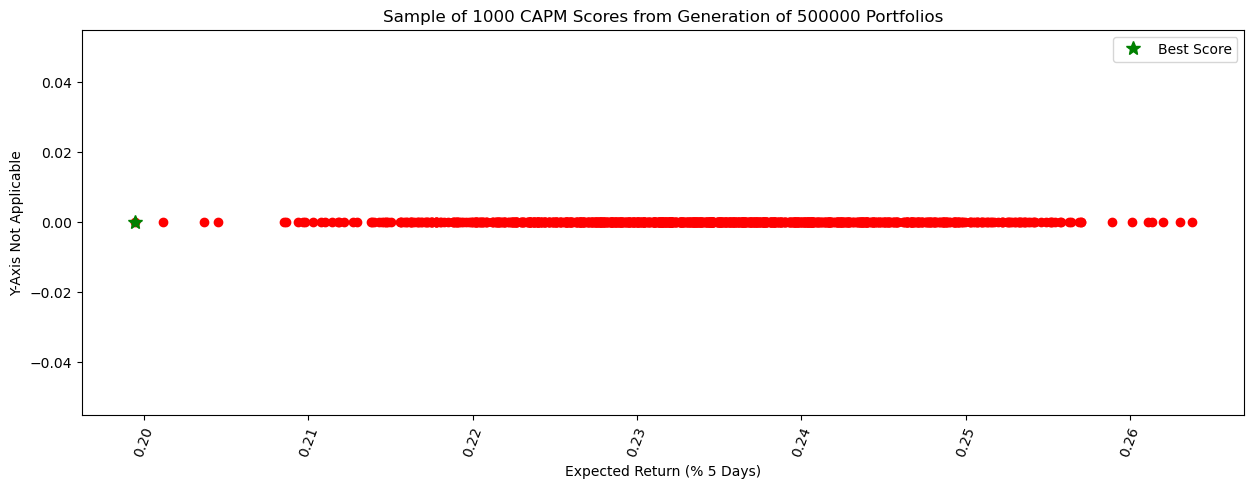

In [268]:
# Plot the data, pinpoint best score
plt.scatter(capm_examples, y_values, color = 'r')
plt.plot(port_expected_return, 0, marker = '*', color = 'g', ls = 'none', ms = 10, label = 'Best Score')

# Set axis and title
plt.title(f'Sample of {num_data_points} CAPM Scores from Generation of {num_hypothetical_portfolios} Portfolios')
plt.xlabel(f'Expected Return (% {frequency})')
plt.xticks(rotation = 70)
plt.ylabel('Y-Axis Not Applicable')

# Change size of graph
plt.gcf().set_size_inches(15, 5)

plt.legend(loc = 'best')

plt.show()

#### 4.3 Returns Check With Low Volatility ETF Comparison

We provide a "performance check", where we can input two days (one_period_start and one_period_end) and track the return of our portfolio in comparison to a low volatility ETF (referred to as the "fund" or the "benchmark"). This section is a precursor to section 4.4 where we will graph more detailed information.

We use an analysis period that begins after the end of the portfolio creation analysis period, to prevent look-ahead bias.

We are using the "iShares MSCI USA Min Vol Factor ETF" (USMV) as the reference fund because it is a US total-market, broad-based, multi-factor fund. It is about as close of a security as we will get to our portfolio in terms of scope and goals. It also has over 29 billion USD net assets, and is owned by iShares, so it's reputable and well-funded. We set it as our "benchmark".

<b>If we are able to outperform* a multi-billion dollar ETF, skillfully curated by the world's largest asset manager, which shares comparable investment objectives and portfolio characteristics to ours, with a portfolio comprised of stocks we barely researched (and with way fewer stocks overall), crafted by quantitative analysis, we consider this project a success. </b>

\* Outperform in terms of our goal.

In [269]:
# MODIFIABLE #

fund_ticker = 'USMV'
fund_name = 'iShares MSCI USA Min Vol Factor ETF'

We first define a simple percent change function. We do this for the sake of clarity and cleanliness, since we use its functionality multiple times in our analysis. It returns the actual percentage, since we use it mostly for analysis and not calculation.

In [270]:
# Provides the percent change from the first price to the last price of a list of prices
def get_pct_change(prices):
    # First and last price
    start = prices[0]
    end = prices[-1]

    # Calculate
    diff = end - start
    pctchange = diff / start * 100

    return(pctchange)

Now we define our analysis dates, and retrieve the closing prices for the fund and the portfolio across those dates.

In [271]:
# MODIFIABLE #

# For graphing the returns between two dates over multiple periods (4.4)
#   MUST BE VALID TRADING DAYS
returns_check_start = '2023-05-03' # Recommended to be as close as possible to variable 'end'
returns_check_end = '2023-07-07'

In [272]:
# MODIFIABLE #

# Subset of returns_check_* to check for one period (should be numdays trading days, 5 trading days here)
#   MUST BE VALID TRADING DAYS
one_period_start = '2023-06-08'
one_period_end = '2023-06-15'

In [273]:
# For analysis, how many trading days per period
tdays_per_period = numdays

In [274]:
analysis_portfolio_closing_dict = {}

# Get ticker prices for analysis dates
for ticker in valid_tickers:
    tick_obj = Stock(ticker = ticker)
    tick_hist = tick_obj.history(start = returns_check_start, end = returns_check_end, interval = '1d')

    analysis_portfolio_closing_dict[ticker] = tick_hist['Close']

analysis_portfolio_closing_df = pd.DataFrame(analysis_portfolio_closing_dict)

# Get fund prices for analysis dates
analysis_fund_closing_dict = {}

fund_obj = Stock(ticker = fund_ticker)
analysis_fund_closing_df = fund_obj.history(start = returns_check_start, end = returns_check_end, interval = '1d')

In [275]:
# Grab number of implied periods, edit end date of DataFrames to reflect tdays_per_period * num_periods trading days (slice to new end date)

analysis_index = analysis_fund_closing_df.index
num_periods = (len(analysis_index) - 1) // tdays_per_period
returns_check_end = analysis_index[num_periods * tdays_per_period]

analysis_fund_closing_df = analysis_fund_closing_df.loc[returns_check_start : returns_check_end, :]
analysis_portfolio_closing_df = analysis_portfolio_closing_df.loc[returns_check_start : returns_check_end, :]

We collect the prices for the weighted portfolio and the fund across the one_period_start and one_period_end dates.

In [276]:
# Get prices from start date to end date
one_period_fund_prices = analysis_fund_closing_df['Close'].loc[one_period_start:one_period_end].values.tolist()

In [277]:
# Reorder the columns of the DataFrame according to tickers_uniform_order
analysis_portfolio_closing_df = analysis_portfolio_closing_df[tickers_uniform_order]

# We will scale each price such that the first price of each ticker is 'capital' multiplied by their weight in the portfolio
#  (Which is the allocation of capital to that security)
for c in range(num_ticks_final):
    column = analysis_portfolio_closing_df.iloc[:, c]
    # If startPrice * scale = allocation = weight * capital, then scale = (weight * capital) / startPrice
    scale = (optimal_weighting[c] * capital) / column[0]

    # Applying scale
    for row in range(0, len(column.index)):
        column[row] *= scale

# Grab a sum of the rows (portfolio value)
analysis_portfolio_closing_df['WEIGHTED TOTAL'] = analysis_portfolio_closing_df.sum(axis = 1)
analysis_portfolio_closing_df = analysis_portfolio_closing_df[['WEIGHTED TOTAL']]

one_period_portfolio_prices = analysis_portfolio_closing_df.loc[one_period_start:one_period_end, 'WEIGHTED TOTAL'].values.tolist()

Now we calculate the percent change of the portfolio and fund over the specified time frame, and present the results. Here, the user can see how the portfolio's performance compares to the estimated performance, as well as the benchmark.

In [278]:
# Get returns
fund_return = get_pct_change(one_period_fund_prices)
port_return = get_pct_change(one_period_portfolio_prices)

# Summary
print(f"Return of portfolio from {one_period_start} to {one_period_end}: {np.round(port_return, 2)}%.")
print(f"Expected return for time period \"{frequency}\" for reference: {np.round(port_expected_return, 2)}%.")
print(f"Return of fund \"{fund_name}\" during this time period for reference: {np.round(fund_return, 2)}%.")

Return of portfolio from 2023-06-08 to 2023-06-15: 0.35%.
Expected return for time period "5 Days" for reference: 0.2%.
Return of fund "iShares MSCI USA Min Vol Factor ETF" during this time period for reference: 2.24%.


#### 4.4 Graphed Returns Check With Additional Data and Low Volatility ETF Comparison

In this section, we graph metrics related to portfolio performance over a time period following the portfolio creation analysis period.
    
We use this information to assess our portfolio. Specifically, 6 main characteristics should be present:
     
1. The average return of the portfolio (blue line) should be close to the expected return of the portfolio (blue dotted line).
2. The average return of the portfolio should be closer to 0% (yellow dotted / dashed line) than the fund's average return (red line).
3. The average distance from a 0% return of our portfolio should be smaller than that of the fund.
4. The portfolio should have a greater percentage of returns closer to 0% than the fund.
5. The standard deviation of portfolio returns should be relatively low.
6. The absolute total return of the portfolio should be lower than that of the fund.

If all of these characteristics are present, we consider the portfolio a success, as this would indicate we have made a good prediction of expected return, beat the benchmark in terms of our goal, and have a system that is likely to perform well if run with different information, or over a different time period.

First, we gather a list of closing prices.

In [279]:
# Grab price information across all dates (DataFrame)
many_periods_fund_prices = analysis_fund_closing_df['Close'].values.tolist()
many_periods_portfolio_prices = analysis_portfolio_closing_df['WEIGHTED TOTAL'].values.tolist()

# For reference when adding dates for x axis
portfolio_prices_series = analysis_portfolio_closing_df.loc[:, 'WEIGHTED TOTAL']

Then, we grab a list of daily returns for every specified number of trading days over the specified number of intervals from the specified start date (returns_check_start) to the specified end date (returns_check_end). We also calculate the total return for the portfolio and fund.

In [280]:
fund_returns = []
port_returns = []
x_axis = []

# Grab the daily returns for each period specified by the user, add to list
for p in range(num_periods):
    start_index = p * tdays_per_period
    end_index = start_index + tdays_per_period + 1

    # Grabbing price data for the current interval
    fund_interval = many_periods_fund_prices[start_index : end_index]
    portfolio_interval = many_periods_portfolio_prices[start_index : end_index]

    # Convert to percent change
    fund_returns.append(get_pct_change(fund_interval))
    port_returns.append(get_pct_change(portfolio_interval))

    # Grab end date of interval for graphing purposes
    x_axis.append(portfolio_prices_series[start_index : end_index].index[-1])

In [281]:
# Get the total return (%)
portfolio_total_return = get_pct_change(many_periods_portfolio_prices)
fund_total_return = get_pct_change(many_periods_fund_prices)

Finally, we plot all of the data, along with some additional statistics.

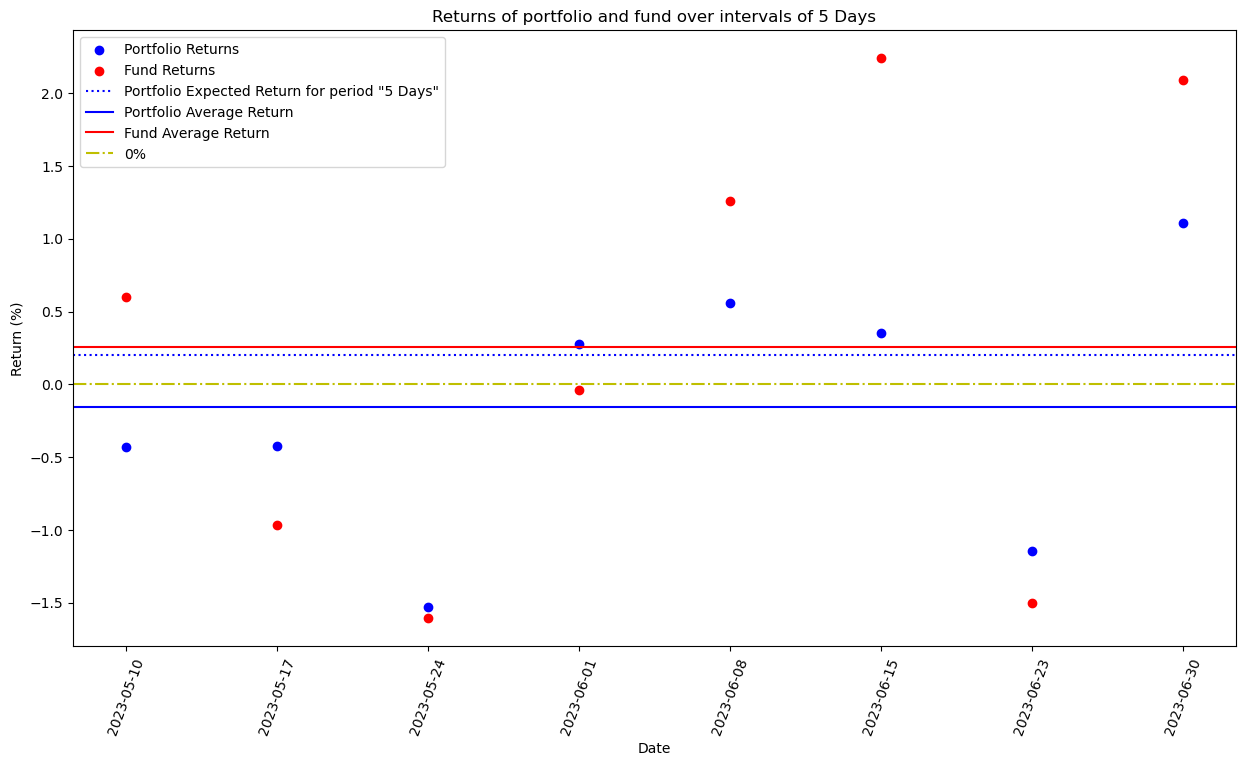

Absolute average distance from 0% return; portfolio: 0.73%
Absolute average distance from 0% return; iShares MSCI USA Min Vol Factor ETF: 1.29%

% of weekly returns in portfolio closer to 0% than iShares MSCI USA Min Vol Factor ETF: 87.5%

Standard deviation of portfolio returns: 0.83%

Portfolio's total return: -1.26%
Fund's total return: 2.01%


In [282]:
# Plot the data, set reference lines for portfolio expected return and 0% return
plt.scatter(x_axis, port_returns, color = 'b', label = 'Portfolio Returns')
plt.scatter(x_axis, fund_returns, color = 'r', label = 'Fund Returns')

plt.axhline(y = port_expected_return, color = 'b', linestyle = ':', label = f'Portfolio Expected Return for period \"{frequency}\"')

plt.axhline(y = np.mean(port_returns), color = 'b', linestyle = '-', label = 'Portfolio Average Return')
plt.axhline(y = np.mean(fund_returns), color = 'r', linestyle = '-', label = 'Fund Average Return')

plt.axhline(y = 0, color = 'y', linestyle = '-.', label = '0%')

# Set axis and title
plt.title(f'Returns of portfolio and fund over intervals of {frequency}')
plt.xlabel(f'Date')
plt.xticks(rotation = 70)
plt.ylabel(f'Return (%)')
plt.legend(loc = 'best')

# Change size of graph
plt.gcf().set_size_inches(15, 8)
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------------------#

# Grab average distance of data points from 0%
returns_abs = [abs(x) for x in port_returns]
fund_returns_abs = [abs(x) for x in fund_returns]
returns_adf0 = np.round(np.mean(returns_abs), 2)
fund_returns_adf0 = np.round(np.mean(fund_returns_abs), 2)

# Calculate amount of times our portfolio is closer to 0% return than the fund
closer = 0

for i in range(len(returns_abs)):
    if returns_abs[i] < fund_returns_abs[i]:
        closer += 1

closer = np.round(closer / len(returns_abs) * 100, 2)

# Conclusion
print(f"Absolute average distance from 0% return; portfolio: {returns_adf0}%")
print(f"Absolute average distance from 0% return; {fund_name}: {fund_returns_adf0}%")

print(f"\n% of weekly returns in portfolio closer to 0% than {fund_name}: {closer}%")

print(f"\nStandard deviation of portfolio returns: {np.round(np.std(port_returns), 2)}%")

print(f"\nPortfolio's total return: {np.round(portfolio_total_return, 2)}%")
print(f"Fund's total return: {np.round(fund_total_return, 2)}%")

## 5. PORTFOLIO TO CSV, CONSIDERATIONS, AND CONCLUSION

#### 5.1 Output Final Information to .csv File

In [283]:
# Final DataFrame, output to csv
stocks_final = portfolio_final[['Ticker', 'Shares']]
stocks_final.to_csv("csv/final_portfolio.csv", encoding='utf-8')

#### 5.2 Considerations

Stock selection - It's hard to make something out of nothing. For this program to run well, the stocks must be selected with low volatility and offsetting correlation in mind. Low volatility is especially important.

Beta - Low beta DOES NOT equal low volatility in all cases. This was one of the reasons we used the points system as part of the consideration when selecting the final portfolio weights. Sometimes, beta can sway the simulation to more heavily favour correlation as a factor, since lower correlation = lower beta.

Analysis period - It was found that a mid-sized portfolio selection analysis period relative to the investment horizon was generally more successful for creating a performant portfolio than a shorter or longer analysis period. We can never really be certain which length of period (or which timeframe) is the best though.

#### 5.3 Conclusion

Our goal was to consume a list of stock tickers, and generate a portfolio that will yield a return as close to 0% as possible. 

We first cleaned up our data to ensure each ticker met certain criteria. Then, we chose the best stocks to use, considering volatility and correlation. We generated five-hundred thousand hypothetical portfolios, and used a Multi-Security Capital Asset Pricing Model to obtain the portfolio whose expected return was the closest to zero. Finally, we performed some data analysis, and explained why the portfolio that our code generated is optimal for achieving our goal.

The portfolio delivered a low absolute average return, with less volatility in the short term, and low momentum in the long term, when compared to the fund. For the given time period, we conclude that we outperformed the fund.

We conclude that our method of creating a portfolio which will yield near-zero returns is efficient, accurate, and performant.

## 6. REFERENCES
- Various Code and Concepts: Notes of Professor James Thompson
- Capital Asset Pricing Model: https://www.investopedia.com/terms/c/capm.asp#toc-the-capm-and-the-efficient-frontier
- Robot Image: http://www.onlinewebfonts.com
- USMV Information: https://www.ishares.com/us/products/239695/ishares-msci-usa-minimum-volatility-etf and https://etfdb.com/advisor_reports/USMV/
- iShares and BlackRock information: https://www.blackrock.com/il/intermediaries/en/themes/ishares-etf
- \#Combining scores and sorting: https://stackoverflow.com/questions/74891387/combining-elements-of-two-lists-based-on-the-indexes-of-two-separate-lists-in-py
- @Weight Generation: https://stackoverflow.com/questions/74527506/creating-a-list-of-n-numbers-between-x-and-y-who-sum-up-to-z